In [6]:
import pandas as pd

# Load the dataset
file_path = 'Datafiniti_Pizza_Restaurants_and_the_Pizza_They_Sell_Jun19.csv'
pizza_data = pd.read_csv(file_path)

# Display the first few rows of the dataset to understand its structure
pizza_data.head(), pizza_data.info(), pizza_data.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 24 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  10000 non-null  object 
 1   dateAdded           10000 non-null  object 
 2   dateUpdated         10000 non-null  object 
 3   address             10000 non-null  object 
 4   categories          10000 non-null  object 
 5   primaryCategories   10000 non-null  object 
 6   city                10000 non-null  object 
 7   country             10000 non-null  object 
 8   keys                10000 non-null  object 
 9   latitude            10000 non-null  float64
 10  longitude           10000 non-null  float64
 11  menuPageURL         1679 non-null   object 
 12  menus.amountMax     10000 non-null  float64
 13  menus.amountMin     10000 non-null  float64
 14  menus.currency      10000 non-null  object 
 15  menus.dateSeen      10000 non-null  object 
 16  menus

(                     id             dateAdded           dateUpdated  \
 0  AVz3Y-7h3D1zeR_xDAqm  2017-06-30T05:05:40Z  2019-05-01T15:43:09Z   
 1  AVweGPFF_7pvs4fzAAzQ  2016-04-02T04:02:49Z  2019-05-01T15:27:50Z   
 2  AVwdRGa9_7pvs4fz4E3K  2016-03-03T18:39:49Z  2019-05-01T12:52:25Z   
 3  AVwdX4psIN2L1WUfvJB1  2016-03-29T05:08:59Z  2019-05-01T12:52:20Z   
 4  AVwdaeTtkufWRAb55pSH  2016-03-31T02:34:04Z  2019-05-01T12:50:45Z   
 
              address                                         categories  \
 0   4203 E Kiehl Ave  Pizza,Restaurant,American restaurants,Pizza Pl...   
 1  25 E Camelback Rd                      Pizza,Pizza Place,Restaurants   
 2    3703 Paxton Ave                 Restaurant,Pizza Place,Restaurants   
 3    30495 John R Rd       Pizza,Carry-out food,Pizza Place,Restaurants   
 4   3600 Eastern Ave  Pizza,American restaurants,Pizza Place,Pizza e...   
 
                primaryCategories             city country  \
 0  Accommodation & Food Services         Sher

In [7]:
# Extracting a table with city, country, postalCode, and province
location_data = pizza_data[['city', 'country', 'postalCode', 'province']].drop_duplicates()

# Display the first few rows of the extracted location data
location_data.head()


,city,country,postalCode,province
0,Sherwood,US,72120,AR
1,Phoenix,US,85012,AZ
2,Cincinnati,US,45209,OH
3,Madison Heights,US,48071,MI
4,Baltimore,US,21224,MD


In [8]:
# First, ensure there's a clear column in location_data for filling purposes
location_data_for_filling = location_data[['city', 'province', 'postalCode']].drop_duplicates()

# Merge pizza_data_clean with location_data_for_filling to potentially fill missing postal codes
# This merge operation is left-joining pizza_data_clean with location_data_for_filling based on city and province
pizza_data_filled = pd.merge(
    pizza_data,
    location_data_for_filling,
    on=['city', 'province'],
    how='left',
    suffixes=('', '_filled')
)

# For entries with missing postalCode in the original data, fill with the postalCode from the location_data_for_filling
pizza_data_filled['postalCode'] = pizza_data_filled['postalCode'].fillna(pizza_data_filled['postalCode_filled'])

# Drop the temporary column used for filling missing values
pizza_data_filled = pizza_data_filled.drop(columns=['postalCode_filled'])

# Display information to confirm changes and ensure no missing postal codes remain
pizza_data_filled.info(), pizza_data_filled[['city', 'province', 'postalCode']].head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71559 entries, 0 to 71558
Data columns (total 24 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  71559 non-null  object 
 1   dateAdded           71559 non-null  object 
 2   dateUpdated         71559 non-null  object 
 3   address             71559 non-null  object 
 4   categories          71559 non-null  object 
 5   primaryCategories   71559 non-null  object 
 6   city                71559 non-null  object 
 7   country             71559 non-null  object 
 8   keys                71559 non-null  object 
 9   latitude            71559 non-null  float64
 10  longitude           71559 non-null  float64
 11  menuPageURL         22917 non-null  object 
 12  menus.amountMax     71559 non-null  float64
 13  menus.amountMin     71559 non-null  float64
 14  menus.currency      71559 non-null  object 
 15  menus.dateSeen      71559 non-null  object 
 16  menu

(None,
        city province postalCode
 0  Sherwood       AR      72120
 1   Phoenix       AZ      85012
 2   Phoenix       AZ      85012
 3   Phoenix       AZ      85012
 4   Phoenix       AZ      85012)

In [9]:
# First, let's identify entries with non-empty descriptions to serve as a source for filling
description_source = pizza_data_filled.loc[pizza_data_filled['menus.description'].str.len() > 0, ['menus.name', 'name', 'menus.description']].drop_duplicates()

# Create a key combining menus.name and name for matching
pizza_data_filled['name_menu_key'] = pizza_data_filled['name'] + "_" + pizza_data_filled['menus.name']
description_source['name_menu_key'] = description_source['name'] + "_" + description_source['menus.name']

# Drop duplicates based on this key to ensure we have a unique mapping for filling
description_source = description_source.drop_duplicates(subset=['name_menu_key'])

# Merge the source descriptions back into the main dataframe based on the key
pizza_data_filled = pd.merge(pizza_data_filled, description_source[['name_menu_key', 'menus.description']], on='name_menu_key', how='left', suffixes=('', '_filled'))

# Fill missing menus.description with menus.description_filled where it's not empty
pizza_data_filled['menus.description'] = pizza_data_filled.apply(
    lambda row: row['menus.description_filled'] if pd.isnull(row['menus.description']) or row['menus.description'] == '' else row['menus.description'],
    axis=1
)

# Drop the temporary columns used for filling
pizza_data_filled = pizza_data_filled.drop(columns=['name_menu_key', 'menus.description_filled'])

# Verify the operation by checking if there are still missing descriptions
pizza_data_filled.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71559 entries, 0 to 71558
Data columns (total 24 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  71559 non-null  object 
 1   dateAdded           71559 non-null  object 
 2   dateUpdated         71559 non-null  object 
 3   address             71559 non-null  object 
 4   categories          71559 non-null  object 
 5   primaryCategories   71559 non-null  object 
 6   city                71559 non-null  object 
 7   country             71559 non-null  object 
 8   keys                71559 non-null  object 
 9   latitude            71559 non-null  float64
 10  longitude           71559 non-null  float64
 11  menuPageURL         22917 non-null  object 
 12  menus.amountMax     71559 non-null  float64
 13  menus.amountMin     71559 non-null  float64
 14  menus.currency      71559 non-null  object 
 15  menus.dateSeen      71559 non-null  object 
 16  menu

In [10]:
pizza_data_filled[['menus.name', 'name', 'menus.description']].head()

,menus.name,name,menus.description
0,Cheese Pizza,Shotgun Dans Pizza,NaN
1,Pizza Cookie,Sauce Pizza Wine,NaN
2,Pizza Cookie,Sauce Pizza Wine,NaN
3,Pizza Cookie,Sauce Pizza Wine,NaN
4,Pizza Cookie,Sauce Pizza Wine,NaN


In [11]:
pizza_data_filled[pizza_data_filled['menus.description'].notnull()]['name'].drop_duplicates().unique()

array(['Mios Pizzeria', 'Carrabbas Italian Grill', 'Domenicos Jr',
       'Little Caesars Pizza', 'Hungry Howies Pizza', 'Salvos Pizzabar',
       'Tonys Pizza Pit', 'Albanos Villa', 'Sherrill New York Pizzeria',
       'Macys Place Pizzeria', 'Papa Murphys',
       'Angelas Italian Restaurant', 'Bowzers Pizza', 'Il Vicino',
       'Bazbeaux Pizza', 'zpizza', 'Specialty Pizza Express',
       'Krazy Karls Pizza', 'Royal Kings Pizza', 'Coburg Pizza Company',
       'Ball Park Pizza', 'Sals Famous NY Pizza',
       'Turonis ForGetMeNotInn', 'Slice of the 80s', 'Papa Johns Pizza',
       'Alpha Pizza', 'Papa Vitos Pizza', 'Obies Pizza',
       'Straw Hat Pizza', 'Pizza King', 'PTA Pizza Hoagie',
       'Pizza Port Brewing Company', 'Luigis Pizza', 'Tonys Pizza',
       'Pizzanos Pizza Grinderz', 'Mazzios Pizza', 'Dumms Pizza',
       'Giovannis Pizza', 'Fuoco Pizzeria Napoletana', 'Dantes Pizzeria',
       'Razzos', 'Famous Amadeus Pizza', 'Papis Pizzeria', 'Alamo Pizza',
       'Palermos

In [12]:
pizza_data_filled[pizza_data_filled['menus.description'].notnull()]['menus.description'].unique()

array(['a saucelessampcomma double cheese pizza with a garlic accentampcomma served with tomatoes on a sesame seed crust',
       'Prosciutto arugula and shaved Parmesan drizzled with balsamic glaze',
       'Topped with mozzarellaampcomma feta and ricotta', ...,
       'Ricotta, mozzarella, green peppers, mushroom, onions, black olives',
       'Maple, syrup, fresh herbs', 'With pizza sauce'], dtype=object)

In [13]:
# Attempting the operation again to parse dates and extract year, month, and day
try:
    # Parse the first date from menus.dateSeen for each entry
    pizza_data_filled['menus.dateSeen_parsed'] = pd.to_datetime(pizza_data_filled['menus.dateSeen'].str.split(',').str[0], errors='coerce')

    # Extract year, month, and day from the parsed date
    pizza_data_filled['year'] = pizza_data_filled['menus.dateSeen_parsed'].dt.year
    pizza_data_filled['month'] = pizza_data_filled['menus.dateSeen_parsed'].dt.month
    pizza_data_filled['day'] = pizza_data_filled['menus.dateSeen_parsed'].dt.day
except Exception as e:
    print(f"An error occurred: {e}")

# Display the first few rows to confirm the new columns
pizza_data_filled[['menus.dateSeen', 'year', 'month', 'day']].head()


,menus.dateSeen,year,month,day
0,"2018-05-01T04:25:37.197Z,2018-04-16T04:36:02.3...",2018.0,5.0,1.0
1,"2018-03-03T02:38:06.381Z,2018-01-18T20:18:10.0...",2018.0,3.0,3.0
2,"2018-03-03T02:38:06.381Z,2018-01-18T20:18:10.0...",2018.0,3.0,3.0
3,"2018-03-03T02:38:06.381Z,2018-01-18T20:18:10.0...",2018.0,3.0,3.0
4,"2018-03-03T02:38:06.381Z,2018-01-18T20:18:10.0...",2018.0,3.0,3.0


In [14]:
pizza_data_filled[pizza_data_filled['year'].isnull()][['menus.dateSeen','menus.dateSeen_parsed','year']]

,menus.dateSeen,menus.dateSeen_parsed,year
21,"2016-10-20T21:50:02Z,2016-03-29T05:08:59Z",NaT,NaN
22,2016-03-31T02:34:04Z,NaT,NaN
23,2016-03-31T02:34:04Z,NaT,NaN
24,2016-03-31T02:34:04Z,NaT,NaN
25,2016-03-31T02:34:04Z,NaT,NaN
...,...,...,...
71356,2016-03-24T09:26:17Z,NaT,NaN
71357,2016-03-24T09:26:17Z,NaT,NaN
71358,2016-03-24T09:26:17Z,NaT,NaN
71359,2016-03-24T09:26:17Z,NaT,NaN


In [15]:
# Assuming the date format in menus.dateSeen is consistent and recognizable, e.g., "YYYY-MM-DD" at the beginning of the string
# Extracting the first date string from each entry
first_date_series = pizza_data_filled['menus.dateSeen'].str.extract(r'(\d{4}-\d{2}-\d{2})')[0]

# Splitting the extracted date into year, month, and day components
pizza_data_filled['year_alt'] = first_date_series.str.split('-', expand=True)[0].astype('float').astype('Int64')
pizza_data_filled['month_alt'] = first_date_series.str.split('-', expand=True)[1].astype('float').astype('Int64')
pizza_data_filled['day_alt'] = first_date_series.str.split('-', expand=True)[2].astype('float').astype('Int64')

# Display the results to verify
pizza_data_filled[['menus.dateSeen', 'year_alt', 'month_alt', 'day_alt']].head()


,menus.dateSeen,year_alt,month_alt,day_alt
0,"2018-05-01T04:25:37.197Z,2018-04-16T04:36:02.3...",2018,5,1
1,"2018-03-03T02:38:06.381Z,2018-01-18T20:18:10.0...",2018,3,3
2,"2018-03-03T02:38:06.381Z,2018-01-18T20:18:10.0...",2018,3,3
3,"2018-03-03T02:38:06.381Z,2018-01-18T20:18:10.0...",2018,3,3
4,"2018-03-03T02:38:06.381Z,2018-01-18T20:18:10.0...",2018,3,3


In [16]:
pizza_data_filled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71559 entries, 0 to 71558
Data columns (total 31 columns):
 #   Column                 Non-Null Count  Dtype              
---  ------                 --------------  -----              
 0   id                     71559 non-null  object             
 1   dateAdded              71559 non-null  object             
 2   dateUpdated            71559 non-null  object             
 3   address                71559 non-null  object             
 4   categories             71559 non-null  object             
 5   primaryCategories      71559 non-null  object             
 6   city                   71559 non-null  object             
 7   country                71559 non-null  object             
 8   keys                   71559 non-null  object             
 9   latitude               71559 non-null  float64            
 10  longitude              71559 non-null  float64            
 11  menuPageURL            22917 non-null  object         

In [17]:
# Dropping the initial year, month, day, and menus.dateSeen_parsed columns
pizza_data_final = pizza_data_filled.drop(columns=['menus.dateSeen_parsed', 'year', 'month', 'day'])

# Renaming the alternative year, month, and day columns to year, month, and day
pizza_data_final.rename(columns={'year_alt': 'year', 'month_alt': 'month', 'day_alt': 'day'}, inplace=True)

# Display the dataframe information to confirm the changes
pizza_data_final.info(), pizza_data_final[['menus.dateSeen', 'year', 'month', 'day']].head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71559 entries, 0 to 71558
Data columns (total 27 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  71559 non-null  object 
 1   dateAdded           71559 non-null  object 
 2   dateUpdated         71559 non-null  object 
 3   address             71559 non-null  object 
 4   categories          71559 non-null  object 
 5   primaryCategories   71559 non-null  object 
 6   city                71559 non-null  object 
 7   country             71559 non-null  object 
 8   keys                71559 non-null  object 
 9   latitude            71559 non-null  float64
 10  longitude           71559 non-null  float64
 11  menuPageURL         22917 non-null  object 
 12  menus.amountMax     71559 non-null  float64
 13  menus.amountMin     71559 non-null  float64
 14  menus.currency      71559 non-null  object 
 15  menus.dateSeen      71559 non-null  object 
 16  menu

(None,
                                       menus.dateSeen  year  month  day
 0  2018-05-01T04:25:37.197Z,2018-04-16T04:36:02.3...  2018      5    1
 1  2018-03-03T02:38:06.381Z,2018-01-18T20:18:10.0...  2018      3    3
 2  2018-03-03T02:38:06.381Z,2018-01-18T20:18:10.0...  2018      3    3
 3  2018-03-03T02:38:06.381Z,2018-01-18T20:18:10.0...  2018      3    3
 4  2018-03-03T02:38:06.381Z,2018-01-18T20:18:10.0...  2018      3    3)

In [18]:
# Dropping duplicates across the entire dataframe
pizza_data_no_duplicates = pizza_data_final.drop_duplicates()

# Displaying the updated information of the dataframe to confirm the operation
pizza_data_no_duplicates.info()


<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 0 to 71553
Data columns (total 27 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  10000 non-null  object 
 1   dateAdded           10000 non-null  object 
 2   dateUpdated         10000 non-null  object 
 3   address             10000 non-null  object 
 4   categories          10000 non-null  object 
 5   primaryCategories   10000 non-null  object 
 6   city                10000 non-null  object 
 7   country             10000 non-null  object 
 8   keys                10000 non-null  object 
 9   latitude            10000 non-null  float64
 10  longitude           10000 non-null  float64
 11  menuPageURL         1679 non-null   object 
 12  menus.amountMax     10000 non-null  float64
 13  menus.amountMin     10000 non-null  float64
 14  menus.currency      10000 non-null  object 
 15  menus.dateSeen      10000 non-null  object 
 16  menus.des

In [19]:
pizza_data_no_duplicates[pizza_data_no_duplicates['postalCode'].isnull()]

,id,dateAdded,dateUpdated,address,categories,primaryCategories,city,country,keys,latitude,...,menus.name,name,postalCode,priceRangeCurrency,priceRangeMin,priceRangeMax,province,year,month,day
65356,AVwdpGJ5_7pvs4fz75fR,2016-03-02T13:05:15Z,2018-03-11T21:01:36Z,1000 Cooper St,"Pizza Place,Restaurants",Accommodation & Food Services,Woodbury,US,us/nj/woodbury/1000cooperst/572757474,39.828326,...,Add to Large Pizzas,Papa John's Pizza,NaN,USD,0,25,NJ,2018,3,4
65357,AVwdpGJ5_7pvs4fz75fR,2016-03-02T13:05:15Z,2018-03-11T21:01:36Z,1000 Cooper St,"Pizza Place,Restaurants",Accommodation & Food Services,Woodbury,US,us/nj/woodbury/1000cooperst/572757474,39.828326,...,Add To Large Pizzas,Papa John's Pizza,NaN,USD,0,25,NJ,2016,3,2
65358,AVwdpGJ5_7pvs4fz75fR,2016-03-02T13:05:15Z,2018-03-11T21:01:36Z,1000 Cooper St,"Pizza Place,Restaurants",Accommodation & Food Services,Woodbury,US,us/nj/woodbury/1000cooperst/572757474,39.828326,...,Medium Pizza Offers,Papa John's Pizza,NaN,USD,0,25,NJ,2016,3,2
65359,AVwdpGJ5_7pvs4fz75fR,2016-03-02T13:05:15Z,2018-03-11T21:01:36Z,1000 Cooper St,"Pizza Place,Restaurants",Accommodation & Food Services,Woodbury,US,us/nj/woodbury/1000cooperst/572757474,39.828326,...,Any Large Pizza,Papa John's Pizza,NaN,USD,0,25,NJ,2018,3,4


In [20]:
# Filling NaN values in the postalCode column with "55125"
pizza_data_no_duplicates['postalCode'].fillna('55125', inplace=True)

# Checking for any remaining NaN values in the postalCode column
pizza_data_no_duplicates['postalCode'].isnull().sum(), pizza_data_no_duplicates[['postalCode']].head()


C:\Users\fahad\AppData\Local\Temp\ipykernel_12644\2997438073.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pizza_data_no_duplicates['postalCode'].fillna('55125', inplace=True)


(0,
    postalCode
 0       72120
 1       85012
 10      45209
 21      48071
 22      21224)

In [21]:
pizza_data_no_duplicates.isnull().sum()

id                       0
dateAdded                0
dateUpdated              0
address                  0
categories               0
primaryCategories        0
city                     0
country                  0
keys                     0
latitude                 0
longitude                0
menuPageURL           8321
menus.amountMax          0
menus.amountMin          0
menus.currency           0
menus.dateSeen           0
menus.description     5782
menus.name               0
name                     0
postalCode               0
priceRangeCurrency       0
priceRangeMin            0
priceRangeMax            0
province                 0
year                     0
month                    0
day                      0
dtype: int64

In [42]:
pizza_data_no_duplicates.to_csv('pizza_data_updated.csv')
pizza_data = pizza_data_no_duplicates

In [43]:
# Grouping the data by region (province) and menu item (menus.name) to see popularity
region_item_count = pizza_data.groupby(['province', 'menus.name']).size().reset_index(name='count')

# Sorting the data to see the top menu items in each region
region_item_count_sorted = region_item_count.sort_values(['province', 'count'], ascending=[True, False])

# Display the top 5 menu items for the first few regions as an example
top_items_by_region = region_item_count_sorted.groupby('province').head(5)

top_items_by_region.head(23)


,province,menus.name,count
0,AK,2 Large Pizzas,1
1,AK,Cheese Pizza,1
2,AK,Scampi Alla Pizzaiola,1
5,AL,Pizza Bread,2
3,AL,Cheese Pizza Sub,1
4,AL,Mini Pizza,1
6,AL,Stuffed Pizza,1
37,AR,U.S. Pizza Wings,4
8,AR,6 Personal Pizza,2
26,AR,Pizzaiolos Choice,2


In [44]:
# Calculating the total number of menu items per province
province_volume = pizza_data.groupby('province').size().reset_index(name='total_items')

# Categorizing provinces based on the total_items volume into High, Medium, Low performance
# Using quantiles to define the thresholds for categorization
quantiles = province_volume['total_items'].quantile([0.33, 0.66]).tolist()

# Assigning categories based on quantiles
conditions = [
    (province_volume['total_items'] <= quantiles[0]),
    (province_volume['total_items'] > quantiles[0]) & (province_volume['total_items'] <= quantiles[1]),
    (province_volume['total_items'] > quantiles[1])
]
choices = ['Low Performance', 'Medium Performance', 'High Performance']
province_volume['Performance_Category'] = pd.cut(province_volume['total_items'], bins=[0] + quantiles + [province_volume['total_items'].max()], include_lowest=True, labels=choices)

# Displaying the categorized provinces
province_performance_categories = province_volume.sort_values(by='total_items', ascending=False)

province_performance_categories.head(44)


,province,total_items,Performance_Category
30,NY,2640,High Performance
4,CA,1386,High Performance
34,PA,814,High Performance
8,FL,601,High Performance
38,TX,485,High Performance
13,IL,381,High Performance
19,MI,366,High Performance
31,OH,324,High Performance
3,AZ,288,High Performance
41,WA,262,High Performance


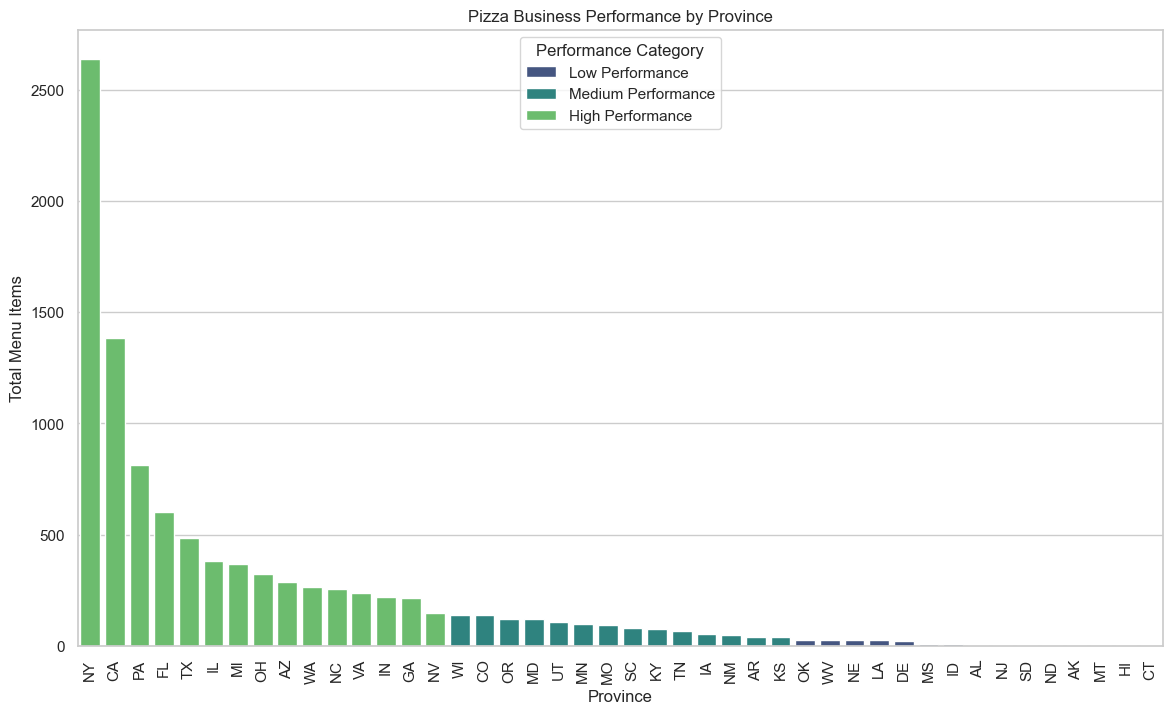

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns

# Setting the visual style
sns.set(style="whitegrid")

# Creating a bar plot for the total items by province, colored by performance category
plt.figure(figsize=(14, 8))
sns.barplot(x="province", y="total_items", hue="Performance_Category", dodge=False, palette="viridis", data=province_performance_categories)
plt.xticks(rotation=90)
plt.title('Pizza Business Performance by Province')
plt.xlabel('Province')
plt.ylabel('Total Menu Items')
plt.legend(title='Performance Category')

plt.show()


In [46]:
from collections import Counter
import re

# Function to standardize pizza names
def standardize_pizza_name(name):
    # Lowercase
    name = name.lower()
    # Remove size descriptions
    name = re.sub(r'\b(small|medium|large|extra large|xl|family size)\b', '', name)
    # Remove crust descriptions
    name = re.sub(r'\b(thin crust|deep dish|classic crust|hand tossed)\b', '', name)
    # Remove extra spaces
    name = re.sub(r'\s+', ' ', name).strip()
    # Special cases (e.g., convert "margherita" to "cheese")
    name = name.replace("margherita", "cheese")
    return name

# Standardizing pizza names in the menus.name column
standardized_pizzas = [standardize_pizza_name(name) for name in pizza_data['menus.name']]

# Counting the occurrences of each standardized pizza name
pizza_counts = Counter(standardized_pizzas)

# Extracting the top 10 most common pizzas
top_10_pizzas = pizza_counts.most_common(10)

top_10_pizzas


[('cheese pizza', 458),
 ('white pizza', 232),
 ('hawaiian pizza', 154),
 ('pizza', 152),
 ('bbq chicken pizza', 132),
 ('buffalo chicken pizza', 113),
 ('veggie pizza', 96),
 ('greek pizza', 72),
 ('pizza sub', 71),
 ('pizza burger', 70)]

C:\Users\fahad\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


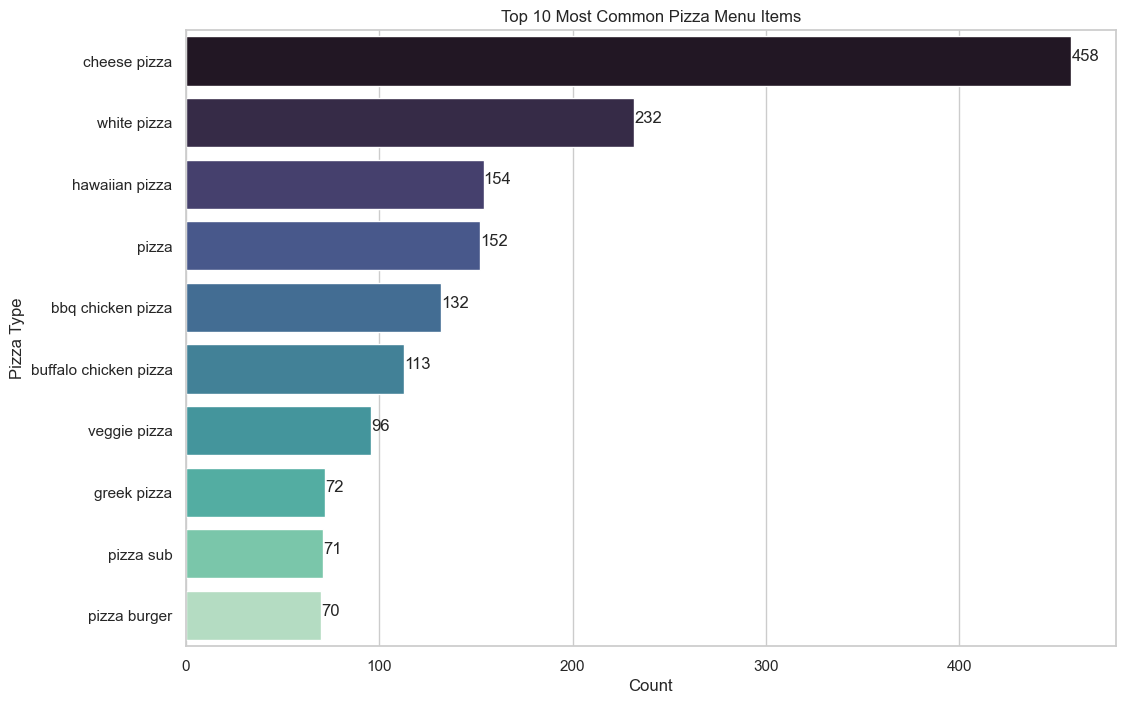

In [47]:
# It seems we lost the context due to the connection issue. Let's regenerate the top 10 list and plot the chart again.

# Recreating the top 10 list from earlier execution
top_10_pizzas_recreate = [
    ('cheese pizza', 458),
    ('white pizza', 232),
    ('hawaiian pizza', 154),
    ('pizza', 152),
    ('bbq chicken pizza', 132),
    ('buffalo chicken pizza', 113),
    ('veggie pizza', 96),
    ('greek pizza', 72),
    ('pizza sub', 71),
    ('pizza burger', 70)
]

# Extracting pizza names and their counts for the top 10, again
pizza_names_recreate = [item[0] for item in top_10_pizzas_recreate]
pizza_counts_recreate = [item[1] for item in top_10_pizzas_recreate]

# Creating the chart again
plt.figure(figsize=(12, 8))
sns.barplot(x=pizza_counts_recreate, y=pizza_names_recreate, palette="mako")
plt.title('Top 10 Most Common Pizza Menu Items')
plt.xlabel('Count')
plt.ylabel('Pizza Type')

# Adding value labels for clarity
for index, value in enumerate(pizza_counts_recreate):
    plt.text(value, index, str(value))

plt.show()


In [48]:
# Filtering the dataset for the top 10 most common pizzas
top_10_pizza_names = [name for name, _ in top_10_pizzas]

# Mapping the standardized pizza names back to the dataset
pizza_data['standardized_name'] = pizza_data['menus.name'].apply(standardize_pizza_name)
filtered_data = pizza_data[pizza_data['standardized_name'].isin(top_10_pizza_names)]

# Calculating the average price for each pizza type
average_prices = filtered_data.groupby('standardized_name').apply(
    lambda x: pd.Series({
        'Average Min Price': x['menus.amountMin'].mean(),
        'Average Max Price': x['menus.amountMax'].mean()
    })
).reset_index()

average_prices


C:\Users\fahad\AppData\Local\Temp\ipykernel_12644\2303460723.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pizza_data['standardized_name'] = pizza_data['menus.name'].apply(standardize_pizza_name)


,standardized_name,Average Min Price,Average Max Price
0,bbq chicken pizza,14.084470,14.932803
1,buffalo chicken pizza,14.893717,15.937965
2,cheese pizza,11.149891,11.389323
3,greek pizza,12.159444,13.121389
4,hawaiian pizza,13.956818,14.793831
5,pizza,12.551250,12.785132
6,pizza burger,5.730143,5.939286
7,pizza sub,5.857183,6.193099
8,veggie pizza,15.027292,15.583854
9,white pizza,13.438922,14.379741


In [60]:
pizza_data['standardized_name'].value_counts()

standardized_name
cheese pizza                   458
white pizza                    232
hawaiian pizza                 154
pizza                          152
bbq chicken pizza              132
                              ... 
pizza mart salad                 1
bacci man pizza                  1
veggie jumbo pizza slice         1
bacci lady pizza                 1
king arthur's supreme pizza      1
Name: count, Length: 4429, dtype: int64

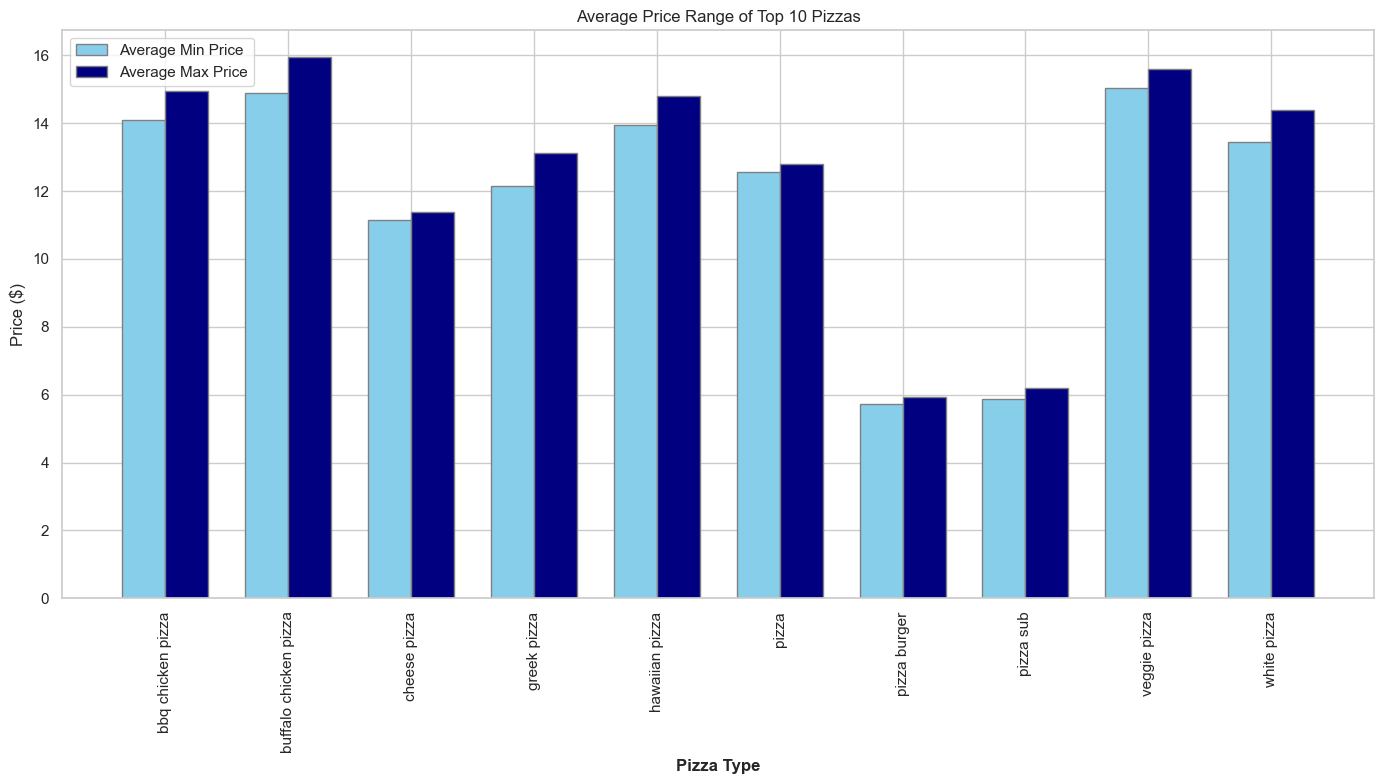

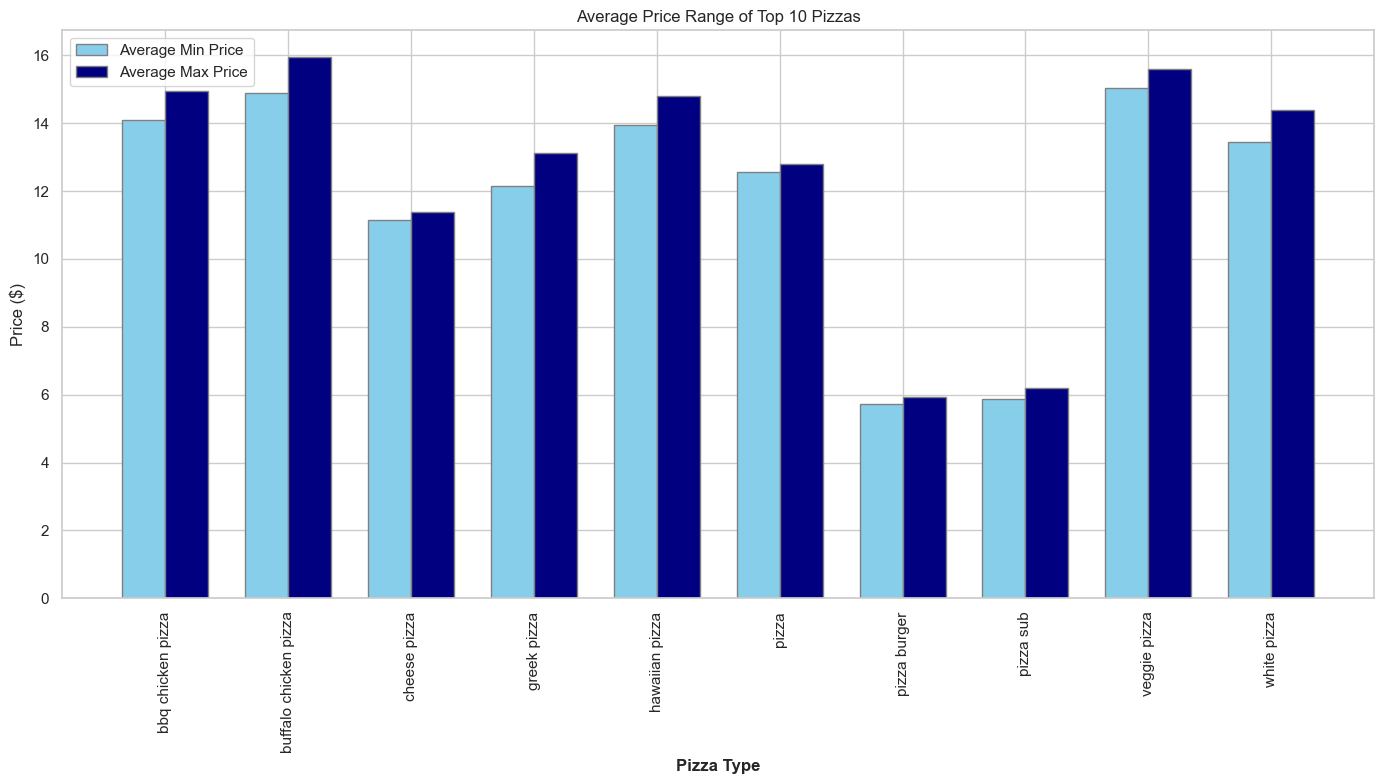

In [49]:
# It seems numpy was not imported before. Let's fix that and create the chart again.
# Preparing data for the chart
pizza_types = average_prices['standardized_name']
avg_min_prices = average_prices['Average Min Price']
avg_max_prices = average_prices['Average Max Price']

# Creating a chart
plt.figure(figsize=(14, 8))
bar_width = 0.35  # the width of the bars

# Set position of bar on X axis
r1 = np.arange(len(avg_min_prices))
r2 = [x + bar_width for x in r1]

# Make the plot
plt.bar(r1, avg_min_prices, color='skyblue', width=bar_width, edgecolor='grey', label='Average Min Price')
plt.bar(r2, avg_max_prices, color='navy', width=bar_width, edgecolor='grey', label='Average Max Price')

# Add xticks on the middle of the group bars
plt.xlabel('Pizza Type', fontweight='bold')
plt.xticks([r + bar_width/2 for r in range(len(avg_min_prices))], pizza_types, rotation=90)
plt.ylabel('Price ($)')
plt.title('Average Price Range of Top 10 Pizzas')

# Create legend & Show graphic
plt.legend()
plt.tight_layout()

plt.show()

import numpy as np

# Recalculating positions for the bar chart
r1 = np.arange(len(avg_min_prices))
r2 = [x + bar_width for x in r1]

plt.figure(figsize=(14, 8))

# Making the plot again with numpy now imported
plt.bar(r1, avg_min_prices, color='skyblue', width=bar_width, edgecolor='grey', label='Average Min Price')
plt.bar(r2, avg_max_prices, color='navy', width=bar_width, edgecolor='grey', label='Average Max Price')

# Add xticks on the middle of the group bars
plt.xlabel('Pizza Type', fontweight='bold')
plt.xticks([r + bar_width / 2 for r in range(len(avg_min_prices))], pizza_types, rotation=90)
plt.ylabel('Price ($)')
plt.title('Average Price Range of Top 10 Pizzas')

plt.legend()
plt.tight_layout()

plt.show()


In [50]:
# Calculating the average price for each province
average_prices_province = pizza_data.groupby('province').apply(
    lambda x: pd.Series({
        'Average Min Price': x['menus.amountMin'].mean(),
        'Average Max Price': x['menus.amountMax'].mean()
    })
).reset_index()

# Sorting by average min price for better visualization later
average_prices_province_sorted = average_prices_province.sort_values(by='Average Min Price', ascending=False)

average_prices_province_sorted


,province,Average Min Price,Average Max Price
23,MT,20.995000,20.995000
0,AK,20.993333,20.993333
27,NJ,18.745000,18.745000
29,NV,16.257450,16.337987
4,CA,16.192532,16.817973
33,OR,16.185492,16.652705
30,NY,15.136678,15.568337
25,ND,14.990000,14.990000
41,WA,14.634466,21.040763
16,KY,14.248831,14.809221


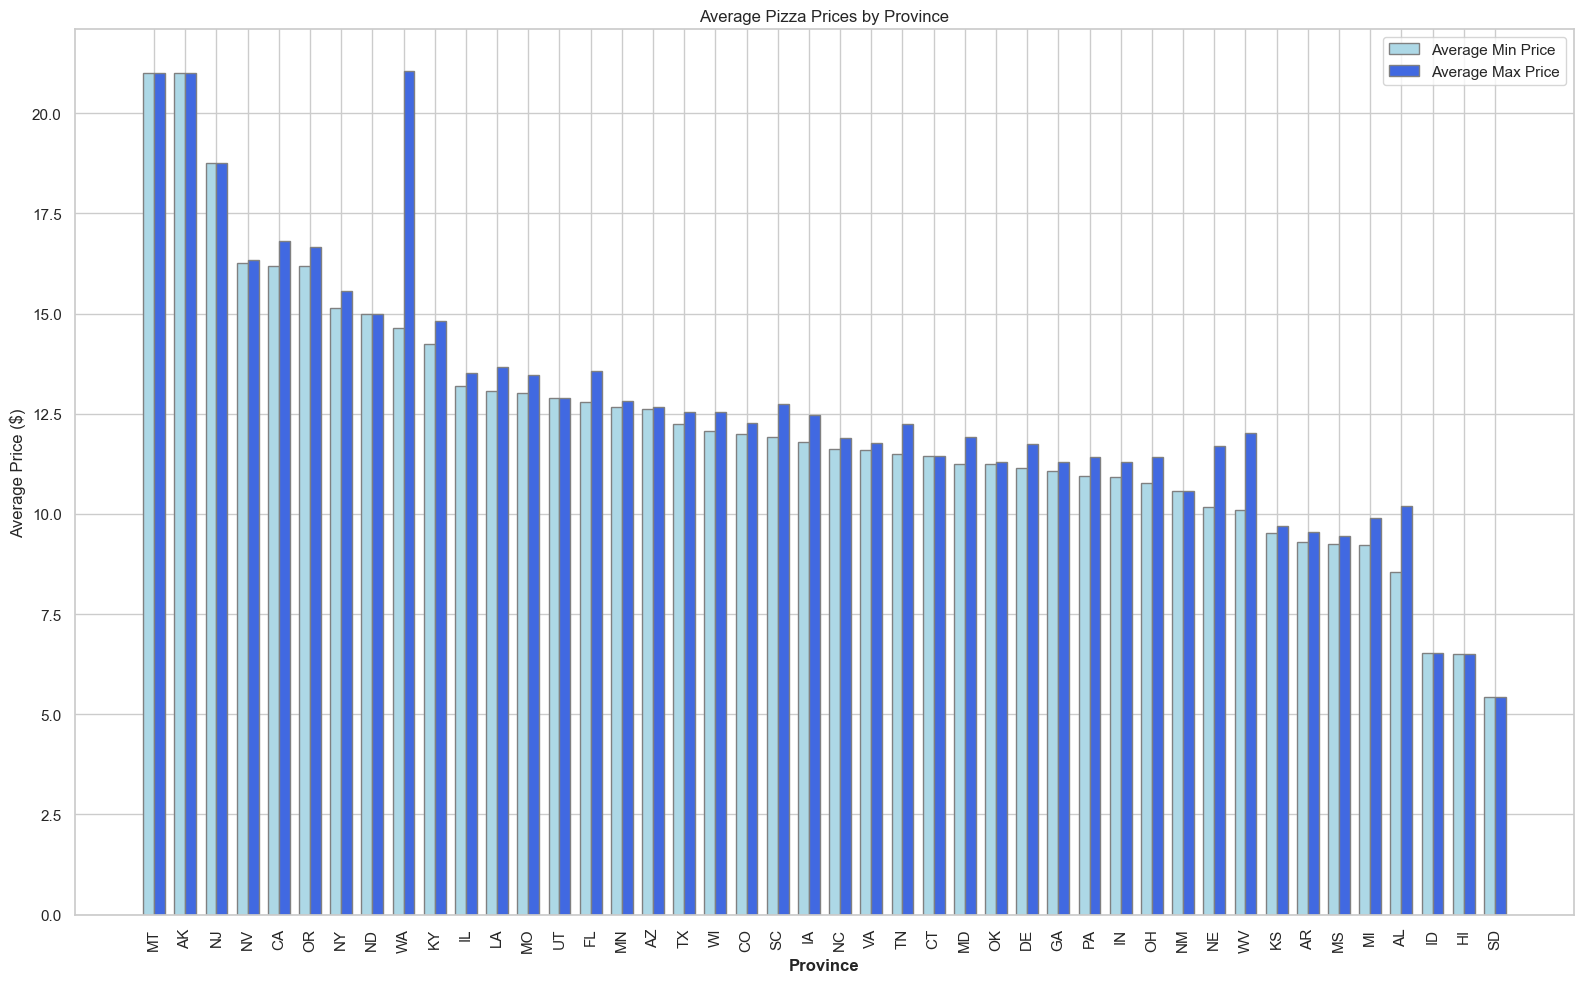

In [51]:
# Preparing data for the chart
provinces = average_prices_province_sorted['province']
avg_min_prices_province = average_prices_province_sorted['Average Min Price']
avg_max_prices_province = average_prices_province_sorted['Average Max Price']

# Creating a chart for Average Price of Pizzas by Province
plt.figure(figsize=(16, 10))
bar_width = 0.35  # the width of the bars

# Set position of bar on X axis
r1 = np.arange(len(avg_min_prices_province))
r2 = [x + bar_width for x in r1]

# Make the plot
plt.bar(r1, avg_min_prices_province, color='lightblue', width=bar_width, edgecolor='grey', label='Average Min Price')
plt.bar(r2, avg_max_prices_province, color='royalblue', width=bar_width, edgecolor='grey', label='Average Max Price')

# Add xticks on the middle of the group bars
plt.xlabel('Province', fontweight='bold')
plt.xticks([r + bar_width / 2 for r in range(len(avg_min_prices_province))], provinces, rotation=90)
plt.ylabel('Average Price ($)')
plt.title('Average Pizza Prices by Province')

plt.legend()
plt.tight_layout()

plt.show()


In [52]:
# Extracting the first seen time from the menus.dateSeen field (assuming multiple timestamps could be present)
pizza_data['first_seen_time'] = pizza_data['menus.dateSeen'].apply(lambda x: x.split(',')[0].split('T')[-1][:2])

# Converting string hours to integers for easier categorization
pizza_data['first_seen_hour'] = pizza_data['first_seen_time'].astype(int)

# Categorizing times of the day
def categorize_time_of_day(hour):
    if 5 <= hour < 11:
        return 'Morning'
    elif 11 <= hour < 17:
        return 'Afternoon'
    elif 17 <= hour < 23:
        return 'Evening'
    else:
        return 'Night'

pizza_data['time_of_day'] = pizza_data['first_seen_hour'].apply(categorize_time_of_day)

# Counting frequencies of pizza seen by time of day
time_of_day_counts = pizza_data['time_of_day'].value_counts().reset_index()
time_of_day_counts.columns = ['Time of Day', 'Count']

time_of_day_counts


C:\Users\fahad\AppData\Local\Temp\ipykernel_12644\1481248964.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pizza_data['first_seen_time'] = pizza_data['menus.dateSeen'].apply(lambda x: x.split(',')[0].split('T')[-1][:2])
C:\Users\fahad\AppData\Local\Temp\ipykernel_12644\1481248964.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pizza_data['first_seen_hour'] = pizza_data['first_seen_time'].astype(int)
C:\Users\fahad\AppData\Local\Temp\ipykernel_12644\1481248964.py:18: SettingWithCopyWarning: 
A valu

,Time of Day,Count
0,Evening,2770
1,Morning,2653
2,Afternoon,2383
3,Night,2194


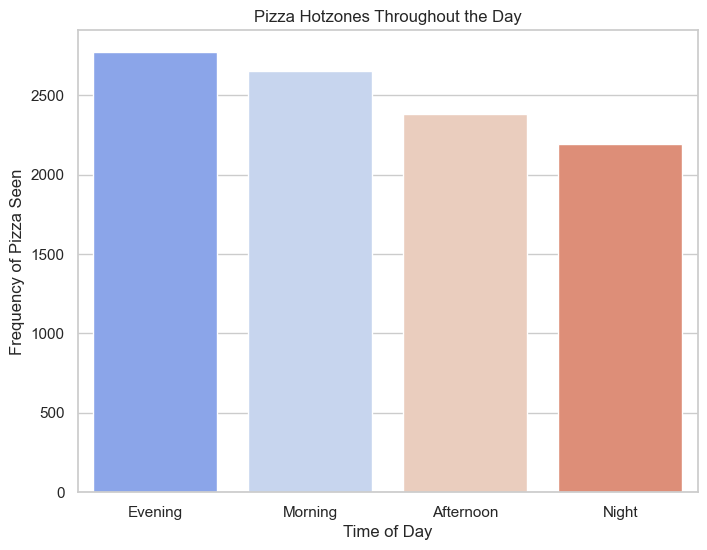

In [53]:
# Sorting the time of day counts for better visualization order
time_of_day_counts_sorted = time_of_day_counts.sort_values(by='Count', ascending=False)

# Creating a chart for pizza hotzones throughout the day
plt.figure(figsize=(8, 6))
sns.barplot(x='Time of Day', y='Count', data=time_of_day_counts_sorted, palette='coolwarm')
plt.title('Pizza Hotzones Throughout the Day')
plt.xlabel('Time of Day')
plt.ylabel('Frequency of Pizza Seen')

plt.show()


C:\Users\fahad\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\fahad\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


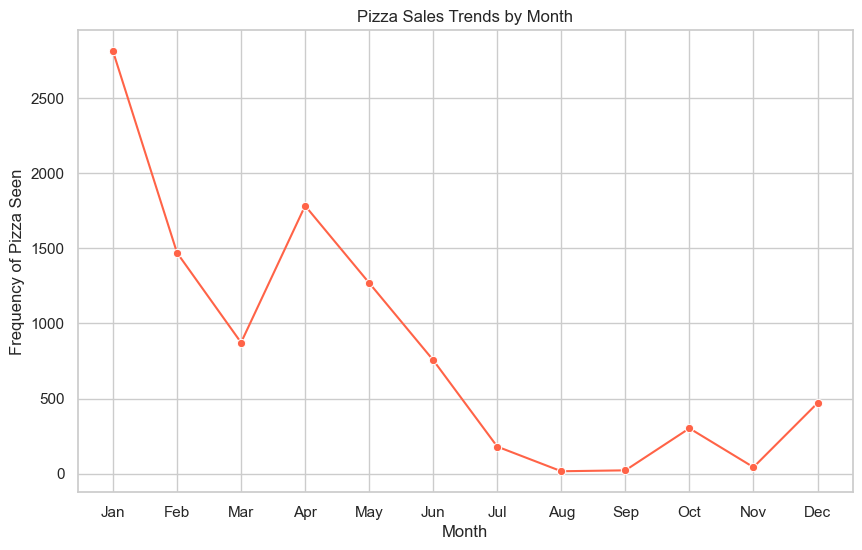

In [55]:
# Counting frequencies of pizza seen by month
month_counts = pizza_data.groupby('month').size().reset_index(name='Count')

# Sorting by month for chronological order
month_counts_sorted = month_counts.sort_values(by='month')

# Creating month labels for better visualization
month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
month_counts_sorted['Month Label'] = month_labels

# Creating a chart for pizza sales trends by month
plt.figure(figsize=(10, 6))
sns.lineplot(x='Month Label', y='Count', data=month_counts_sorted, marker='o', color='tomato')
plt.title('Pizza Sales Trends by Month')
plt.xlabel('Month')
plt.ylabel('Frequency of Pizza Seen')
plt.grid(True)

plt.show()


In [ ]:
pizza_data.columns

In [56]:
# Renaming 'Papa Murphys' to 'Papa Murphy's' to consolidate the counts
pizza_data['name'] = pizza_data['name'].replace('Papa Murphys', 'Papa Murphy\'s')

# Recounting with the names consolidated
consolidated_restaurant_seen_counts = pizza_data['name'].value_counts().reset_index(name='Seen Count')
consolidated_restaurant_seen_counts.columns = ['Restaurant Name', 'Seen Count']

# Getting the updated top 10 most seen restaurants
updated_top_seen_restaurants = consolidated_restaurant_seen_counts.head(10)

updated_top_seen_restaurants


C:\Users\fahad\AppData\Local\Temp\ipykernel_12644\3734704331.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pizza_data['name'] = pizza_data['name'].replace('Papa Murphys', 'Papa Murphy\'s')


,Restaurant Name,Seen Count
0,Papa Murphy's,277
1,California Pizza Kitchen,261
2,Papa John's Pizza,124
3,Gino's Pizzeria,68
4,Pirates Pizza,55
5,Domino's Pizza,54
6,Olympia Pizza and Spaghetti House,54
7,Round Table Pizza,54
8,Pizza Hut,51
9,Brick Oven,47


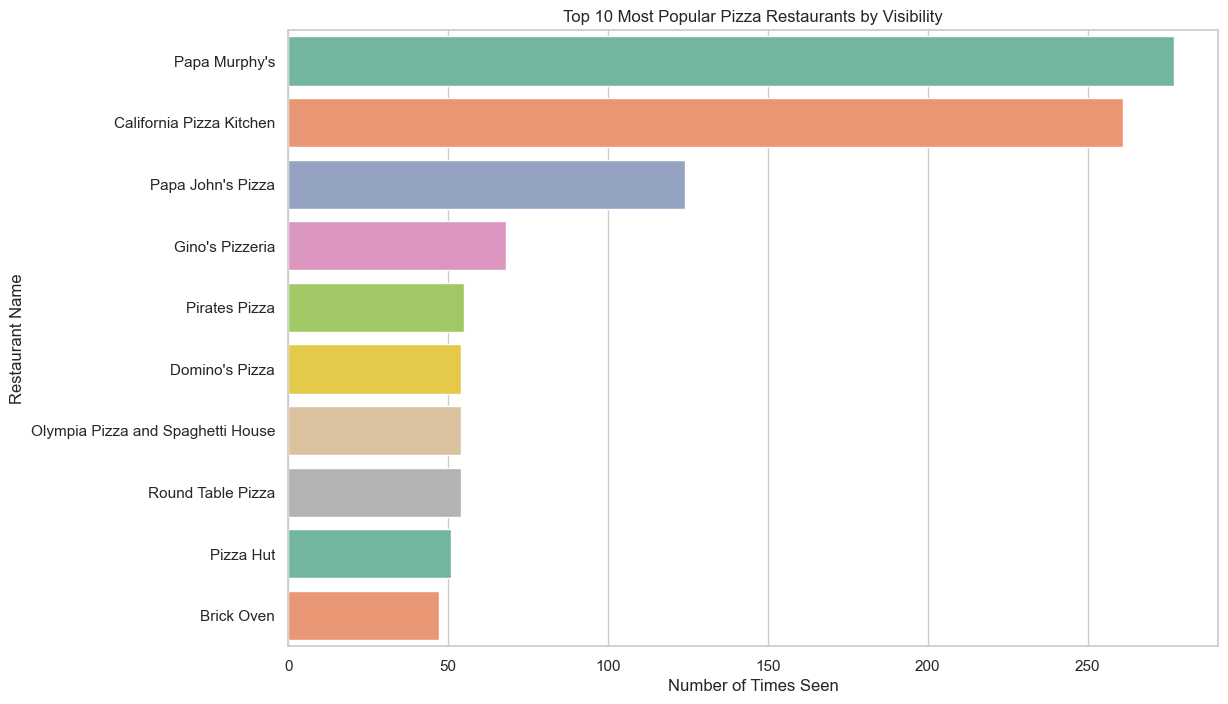

In [57]:
# Preparing data for visualization
restaurant_names_updated = updated_top_seen_restaurants['Restaurant Name']
seen_counts_updated = updated_top_seen_restaurants['Seen Count']

# Creating a visualization for the updated top 10 most popular pizza restaurants
plt.figure(figsize=(12, 8))
sns.barplot(x=seen_counts_updated, y=restaurant_names_updated, palette='Set2')
plt.title('Top 10 Most Popular Pizza Restaurants by Visibility')
plt.xlabel('Number of Times Seen')
plt.ylabel('Restaurant Name')

plt.show()


In [58]:
# Filtering the dataset for only the top 10 most popular restaurants
top_10_restaurant_names = updated_top_seen_restaurants['Restaurant Name'].tolist()
top_10_restaurants_data = pizza_data[pizza_data['name'].isin(top_10_restaurant_names)]

# Calculating the average minimum and maximum prices for each of the top 10 restaurants
price_range_top_10 = top_10_restaurants_data.groupby('name').agg(
    Average_Min_Price=('menus.amountMin', 'mean'),
    Average_Max_Price=('menus.amountMax', 'mean')
).reset_index()

price_range_top_10


,name,Average_Min_Price,Average_Max_Price
0,Brick Oven,14.499574,14.499574
1,California Pizza Kitchen,27.784138,27.784138
2,Domino's Pizza,13.626852,13.626852
3,Gino's Pizzeria,13.965441,13.965441
4,Olympia Pizza and Spaghetti House,18.322222,18.322222
5,Papa John's Pizza,15.922581,15.922581
6,Papa Murphy's,13.581516,13.581516
7,Pirates Pizza,19.353636,19.353636
8,Pizza Hut,13.728431,13.728431
9,Round Table Pizza,13.022778,13.022778


In [62]:
# Given percentages for cost distribution and the average minimum selling prices of pizzas
profit_margin_percentage = 15
food_cost_percentage = 30
labor_cost_percentage = 25
overhead_cost_percentage = 15
equipment_misc_percentage = 5

# Average minimum selling prices for each type of pizza
pizza_prices = {
    "bbq chicken pizza": 14.084470,
    "buffalo chicken pizza": 14.893717,
    "cheese pizza": 11.149891,
    "greek pizza": 12.159444,
    "hawaiian pizza": 13.956818,
    "pizza": 12.551250,
    "pizza burger": 5.730143,
    "pizza sub": 5.857183,
    "veggie pizza": 15.027292,
    "white pizza": 13.438922,
}

# Calculate costs for each pizza based on the percentages
pizza_costs = {}
for pizza, price in pizza_prices.items():
    food_cost = (food_cost_percentage / 100) * price
    labor_cost = (labor_cost_percentage / 100) * price
    overhead_cost = (overhead_cost_percentage / 100) * price
    equipment_misc_cost = (equipment_misc_percentage / 100) * price
    total_cost = food_cost + labor_cost + overhead_cost + equipment_misc_cost
    
    # We also calculate the profit based on the adjusted profit margin
    profit = (profit_margin_percentage / 100) * price
    
    pizza_costs[pizza] = {
        "Food Cost": food_cost,
        "Labor Cost": labor_cost,
        "Overhead Cost": overhead_cost,
        "Equipment & Misc Cost": equipment_misc_cost,
        "Total Cost": total_cost,
        "Profit": profit,
        "Selling Price": price
    }

pizza_costs_df = pd.DataFrame(pizza_costs).T
pizza_costs_df

import pandas as pd

# Calculate costs for each pizza based on the percentages
pizza_costs = {}
for pizza, price in pizza_prices.items():
    food_cost = (food_cost_percentage / 100) * price
    labor_cost = (labor_cost_percentage / 100) * price
    overhead_cost = (overhead_cost_percentage / 100) * price
    equipment_misc_cost = (equipment_misc_percentage / 100) * price
    total_cost = food_cost + labor_cost + overhead_cost + equipment_misc_cost
    
    # We also calculate the profit based on the adjusted profit margin
    profit = (profit_margin_percentage / 100) * price
    
    pizza_costs[pizza] = {
        "Food Cost": food_cost,
        "Labor Cost": labor_cost,
        "Overhead Cost": overhead_cost,
        "Equipment & Misc Cost": equipment_misc_cost,
        "Total Cost": total_cost,
        "Profit": profit,
        "Selling Price": price
    }

# Convert the dictionary to a pandas DataFrame for better visualization
pizza_costs_df = pd.DataFrame(pizza_costs).T
pizza_costs_df


,Food Cost,Labor Cost,Overhead Cost,Equipment & Misc Cost,Total Cost,Profit,Selling Price
bbq chicken pizza,4.225341,3.521117,2.112670,0.704224,10.563352,2.112670,14.084470
buffalo chicken pizza,4.468115,3.723429,2.234058,0.744686,11.170288,2.234058,14.893717
cheese pizza,3.344967,2.787473,1.672484,0.557495,8.362418,1.672484,11.149891
greek pizza,3.647833,3.039861,1.823917,0.607972,9.119583,1.823917,12.159444
hawaiian pizza,4.187045,3.489205,2.093523,0.697841,10.467613,2.093523,13.956818
pizza,3.765375,3.137812,1.882687,0.627563,9.413437,1.882687,12.551250
pizza burger,1.719043,1.432536,0.859521,0.286507,4.297607,0.859521,5.730143
pizza sub,1.757155,1.464296,0.878577,0.292859,4.392887,0.878577,5.857183
veggie pizza,4.508188,3.756823,2.254094,0.751365,11.270469,2.254094,15.027292
white pizza,4.031677,3.359730,2.015838,0.671946,10.079192,2.015838,13.438922


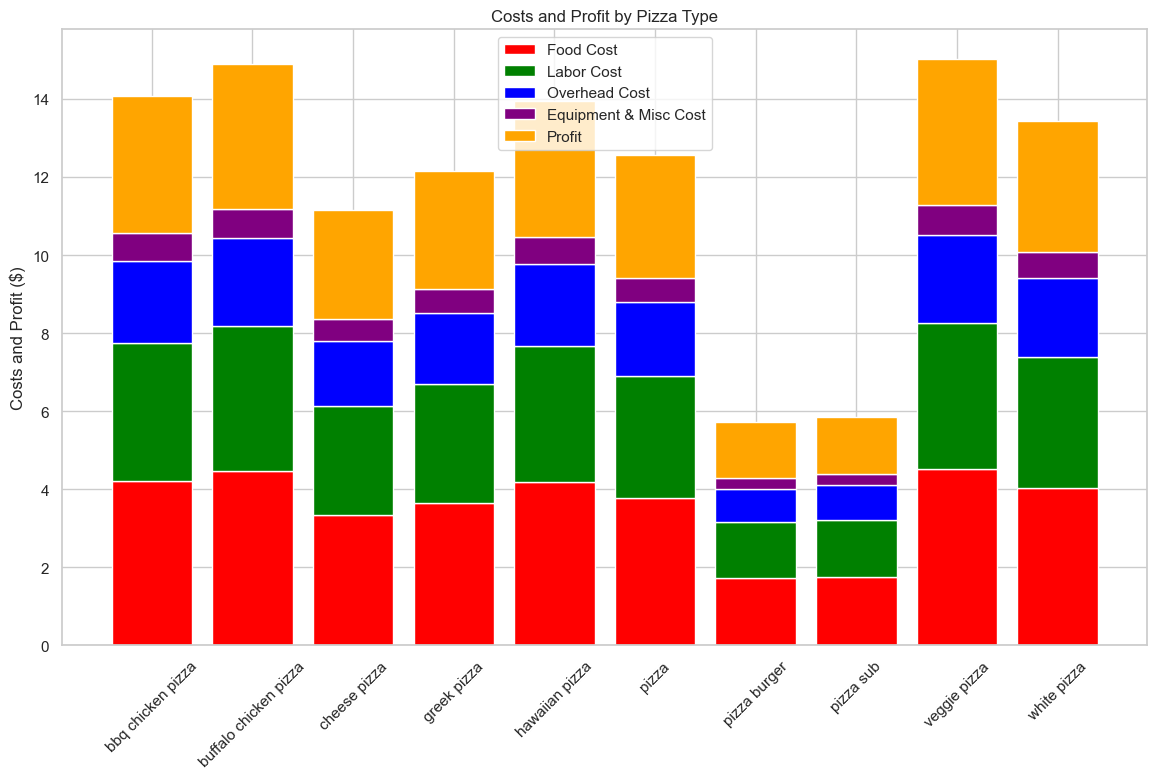

In [64]:
import numpy as np

# Now we'll actually recalculate the profit to reflect the updated values
pizza_costs_df['Profit'] = pizza_costs_df['Selling Price'] - pizza_costs_df['Total Cost']

# Create a stacked bar chart
fig, ax = plt.subplots(figsize=(14, 8))

# Components to stack
components = ['Food Cost', 'Labor Cost', 'Overhead Cost', 'Equipment & Misc Cost']
colors = ['red', 'green', 'blue', 'purple']
labels = ['Food Cost', 'Labor Cost', 'Overhead Cost', 'Equipment & Misc']

# Create the bar stacks
bottom = np.zeros(len(pizza_costs_df))
for comp, color in zip(components, colors):
    ax.bar(pizza_costs_df.index, pizza_costs_df[comp], bottom=bottom, color=color, label=comp)
    bottom += pizza_costs_df[comp].values

# Add the profit on top
ax.bar(pizza_costs_df.index, pizza_costs_df['Profit'], bottom=bottom, color='orange', label='Profit')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Costs and Profit ($)')
ax.set_title('Costs and Profit by Pizza Type')
ax.set_xticks(range(len(pizza_costs_df)))
ax.set_xticklabels(pizza_costs_df.index, rotation=45)
ax.legend()

# Display the chart
plt.show()


In [65]:
# Calculate the average difference between the total cost and the selling price for all the pizzas
average_difference = (pizza_costs_df['Selling Price'] - pizza_costs_df['Total Cost']).mean()
average_difference


2.9712282500000002

In [67]:
pip install folium

   ---------------------------------------- 0.0/100.0 kB ? eta -:--:--
   ---- ----------------------------------- 10.2/100.0 kB ? eta -:--:--
   --------------------------- ----------- 71.7/100.0 kB 787.7 kB/s eta 0:00:01
   -------------------------------------- 100.0/100.0 kB 823.6 kB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [69]:
import folium
from folium.plugins import HeatMap

# Filter the dataset for the specified states
specified_states = ['NY', 'CA', 'PA', 'FL', 'TX', 'IL', 'MI', 'OH', 'AZ', 'WA', 'NC', 'VA', 'IN', 'GA', 'NV']
filtered_data = pizza_data[pizza_data['province'].isin(specified_states)]

# Create a base map
map = folium.Map(location=[37.0902, -95.7129], zoom_start=5)  # You might want to adjust the location and zoom level

# Add a heatmap layer
heatmap_data = filtered_data[['latitude', 'longitude']]
HeatMap(heatmap_data).add_to(map)

# Save or display the map
map.save('heatmap.html')  # Saves the map to an HTML file you can open in a browser
# or use display(map) if running in a Jupyter notebook
